# 1. Importing Libraries

In [1]:
###IMPORTING LIBRARIES

import numpy as np
import tensorflow as tf
import os
from tensorflow.python.framework import ops
import gzip

import mnist_reader
import matplotlib.pyplot as plt


from tf_utils import random_mini_batches, convert_to_one_hot, predict


# 2. Loading Fashion-MNIST dataset from path

In [2]:
###LOADING MNIST DATASET


def load_mnist(path, kind='train'):
   
    """Loading MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)

    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    print("Dataset Loaded")
    
    return images, labels

# 3. Loading Test and Train set Features and Labels

In [3]:
###LOADING TRAIN AND TEST SET FEATURES AND LABELS

X_train, y_train = mnist_reader.load_mnist('C:/Users/evars/OneDrive/Desktop/ENEE633_P2', kind='train')
X_test, y_test = mnist_reader.load_mnist('C:/Users/evars/OneDrive/Desktop/ENEE633_P2', kind='t10k')


# 4. Data Normalization

In [4]:
###NORMALIZING AND CHECKING THE SHAPES OF TRAIN AND TEST SETS



X_train = X_train/255

X_test = X_test/255

print("Feature Train and Test datasets are normalized")

y_train = convert_to_one_hot(y_train, 10)
y_test = convert_to_one_hot(y_test, 10)


#print(X_train[1])

X_train = X_train.reshape(X_train.shape).T   

#y_train = y_train[np.newaxis]

X_test = X_test.reshape(X_test.shape).T   

#y_test = y_test[np.newaxis]

print("Shape of Train set features (X_train) :  ",X_train.shape)
print("Shape of Train set labels (y_train) :  ",y_train.shape)
print("Shape of Test set features (X_test) :  ",X_test.shape)
print("Shape of Test set labels (y_test) :  ",y_test.shape)
#print(X_train[0:783,0])

Feature Train and Test datasets are normalized
Shape of Train set features (X_train) :   (784, 60000)
Shape of Train set labels (y_train) :   (10, 60000)
Shape of Test set features (X_test) :   (784, 10000)
Shape of Test set labels (y_test) :   (10, 10000)


# 5. Creating Placeholders

In [5]:
# Creating Placeholders using tensorflow session: create_placeholders

def create_placeholders(n_x, n_y):
    
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    
    
    return X, Y

In [6]:
# Checking for Placeholders

X, Y = create_placeholders(784, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(784, ?), dtype=float32)
Y = Tensor("Y:0", shape=(10, ?), dtype=float32)


# 6. Initializing Parameters

In [7]:
# Initializing random weights and bias for NN: initialize_parameters

def initialize_parameters():
   
    
    tf.set_random_seed(1)                  
    
    W1 = tf.get_variable("W1", [50, 784], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [50, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [14, 50], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [14, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 14], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

# 7. Forward propagation in Tensorflow

In [9]:
# LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX: forward_propagation

def forward_propagation(X, parameters):
  
    # Dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Using Tensorflow                                   
    Z1 = tf.add(tf.matmul(W1, X), b1)                      
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2) 
    A2 = tf.nn.relu(Z2) 
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    
    return Z3

# 8. Cost Computation

In [11]:
# Cross Entropy loss function: compute_cost 

def compute_cost(Z3, Y):
   
    logits = tf.transpose(Z3)
    labels =  tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
   
    return cost

# 9. Backward Propagation

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 500, minibatch_size = 100, print_cost = True):
    
    ops.reset_default_graph() 
    tf.set_random_seed(1)
    seed = 3
    (n_x, m) = X_train.shape 
    n_y = Y_train.shape[0]
    costs = []
    
    # Creating Placeholders from the above function
    X, Y = create_placeholders(n_x, n_y)
    

    # Initializing parameters
    parameters = initialize_parameters()
    
    # Forward propagation
    Z3 = forward_propagation(X, parameters)
    
    
    # Adding cost function 
    cost = compute_cost(Z3, Y)
    

    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
        
    init = tf.global_variables_initializer()

    # Starting the session
    with tf.Session() as sess:
        
        # Running the initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):

            epoch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                
                epoch_cost += minibatch_cost / num_minibatches

            # Printing the cost at every epoch
            if print_cost == True and epoch % 50 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # Plotting the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train})*100)
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test})*100)
        
        return parameters

Cost after epoch 0: 1.414395
Cost after epoch 50: 0.083237
Cost after epoch 100: 0.040651
Cost after epoch 150: 0.020357
Cost after epoch 200: 0.009163
Cost after epoch 250: 0.003324
Cost after epoch 300: 0.000993
Cost after epoch 350: 0.000269
Cost after epoch 400: 0.000076
Cost after epoch 450: 0.000025


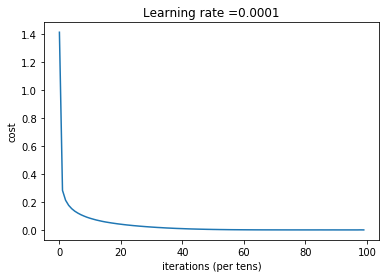

Parameters have been trained!
Train Accuracy: 100.0
Test Accuracy: 96.95000052452087


In [14]:
parameters = model(X_train, y_train, X_test, y_test)